In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys
import re
import pickle as pkl
from pathlib import Path
sys.path.append("../src")

import pandas as pd
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

import constants
from finetune.baseline import evaluate
from gen.util import read_data, write_jsonl

# README

`cd /users/k21190024/study/fact-checking-repos/fever/baseline`

Build TF-IDF: `PYTHONPATH=$PYTHONPATH:src /users/k21190024/study/fact-checking-repos/fever/baseline/src/scripts/build_tfidf.py /users/k21190024/study/fact-checking-repos/fever/baseline/dumps/feverised-climatefever/feverised-climatefever-titleid.db /users/k21190024/study/fact-checking-repos/fever/baseline/fever2-sample/data/index --num-workers 10`

__No need to sample NEI class as Climate-FEVER has evidences for every NEI claim__

IR Tuning: Tune for _k_ nearest pages and _l_ nearest sentences where 1 <= k <= 10 and 1 <= l <= 10 using grid search

RTE Fine Tune: `PYTHONPATH=$PYTHONPATH:src allennlp fine-tune -m /users/k21190024/study/fact-checking-repos/fever/baseline/fever2-sample/data/models/seeded-decomposable_attention.tar.gz -s /users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/rte/[DUMP_PATH] -c /users/k21190024/study/fact-checking-repos/fever/baseline/config/finetune_climatefever_nn_ora_sent.json --include-package rte.parikh.reader`

# IR

In [3]:
ir_p = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/ir")

## Get evaluate results

In [5]:
def multi_ir_evaluate(train_p, dev_p, max_evidence=None):
    train, dev = read_data(train_p), read_data(dev_p)
    train_keys = re.findall(r".*(p\d{1,2})\.(s\d{1,2})", train_p.stem)[0]
    dev_keys = re.findall(r".*(p\d{1,2})\.(s\d{1,2})", dev_p.stem)[0]
    
    key = "".join(train_keys)
    if key != "".join(dev_keys):
        raise Exception("Train and dev files are different! ({0} != {1})".format(train_p.stem, dev_p.stem))
    
    try:
        res = {
            key: {
                "train": evaluate.ClimateFEVERScorer(train, train, oracle_rte=True, oracle_ir=False, max_evidence=max_evidence, score_name="train"),
                "dev": evaluate.ClimateFEVERScorer(dev, dev, oracle_rte=True, oracle_ir=False, max_evidence=max_evidence, score_name="dev")
            }
        }
    except:
        raise Exception(train_p.stem, dev_p.stem)
    else:
        return res

In [72]:
train_pls = sorted(list(ir_p.joinpath("train").iterdir()))
dev_pls = sorted(list(ir_p.joinpath("dev").iterdir()))

eval_nomaxev = Parallel(n_jobs=20)(delayed(multi_ir_evaluate)(tp, dp, None) for tp, dp in zip(train_pls, dev_pls))
with ir_p.joinpath("eval_nomaxevidence.pkl").open("wb") as fn:
    pkl.dump(eval_nomaxev, fn)
    
eval_max5ev = Parallel(n_jobs=20)(delayed(multi_ir_evaluate)(tp, dp, 5) for tp, dp in zip(train_pls, dev_pls))
with ir_p.joinpath("eval_max5evidences.pkl").open("wb") as fn:
    pkl.dump(eval_max5ev, fn)

## Analyse results

In [31]:
with ir_p.joinpath("eval_nomaxevidence.pkl").open("rb") as f1, ir_p.joinpath("eval_max5evidences.pkl").open("rb") as f2:
    eval_nomaxevidence = pkl.load(f1)
    eval_max5evidences = pkl.load(f2)

In [32]:
def to_df(ev_res):
    key = list(ev_res.keys())[0]
    p, s = re.findall(r".*p(\d{1,2})s(\d{1,2})", key)[0]
    
    res = {"n_pages": int(p), "n_sents": int(s)}
    res.update(ev_res[key]["train"].score_to_dict())
    res.update(ev_res[key]["dev"].score_to_dict())
    
    return res

In [33]:
df_evnomax = Parallel(n_jobs=10)(delayed(to_df)(ev) for ev in eval_nomaxevidence)
df_ev5max = Parallel(n_jobs=10)(delayed(to_df)(ev) for ev in eval_max5evidences)

df_evnomax = pd.DataFrame(df_evnomax).sort_values(["n_pages", "n_sents"])
df_ev5max = pd.DataFrame(df_ev5max).sort_values(["n_pages", "n_sents"])

In [34]:
def plot_evidence_curves(df, x_is_page: bool, metric: str, suptitle: str):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5])

    fig.suptitle(suptitle)

    for idx, split in enumerate(["train", "dev"]):
        ax[idx].set_title(split)
        ax[idx].set_xlabel("Pages" if x_is_page else "Sentences")
        ax[idx].set_ylabel(metric)
        for i in range(1, 11):
            df_plt = df.loc[df["n_sents" if x_is_page else "n_pages"] == i, ["n_pages" if x_is_page else "n_sents", f"{split}_{metric}"]]
            if idx == 0:
                ax[idx].plot(df_plt["n_pages" if x_is_page else "n_sents"], df_plt[f"{split}_{metric}"], label="{0} {1}".format(i, "Sentence" if x_is_page else "Pages"))
            else:
                ax[idx].plot(df_plt["n_pages" if x_is_page else "n_sents"], df_plt[f"{split}_{metric}"])

    fig.legend()
    
    return fig, ax

### No max evidence

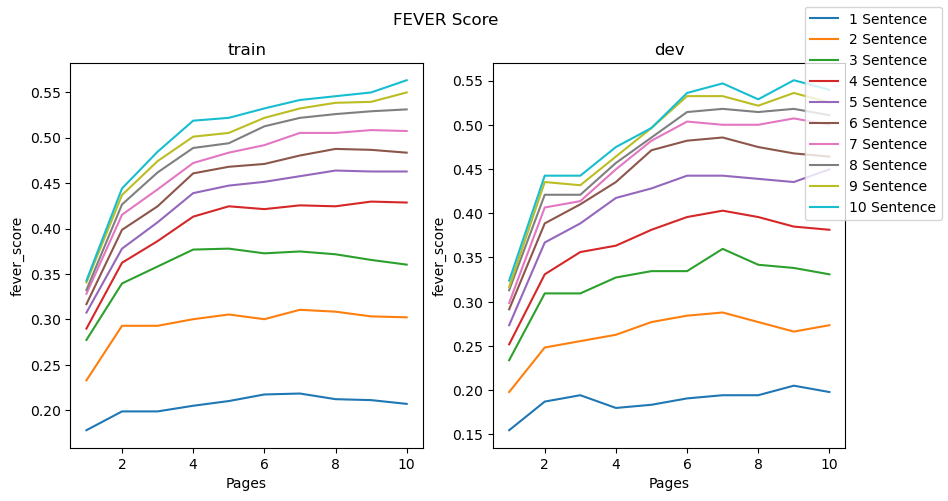

In [35]:
fig_fs, ax_fs = plot_evidence_curves(df_evnomax, x_is_page=True, metric="fever_score", suptitle="FEVER Score")

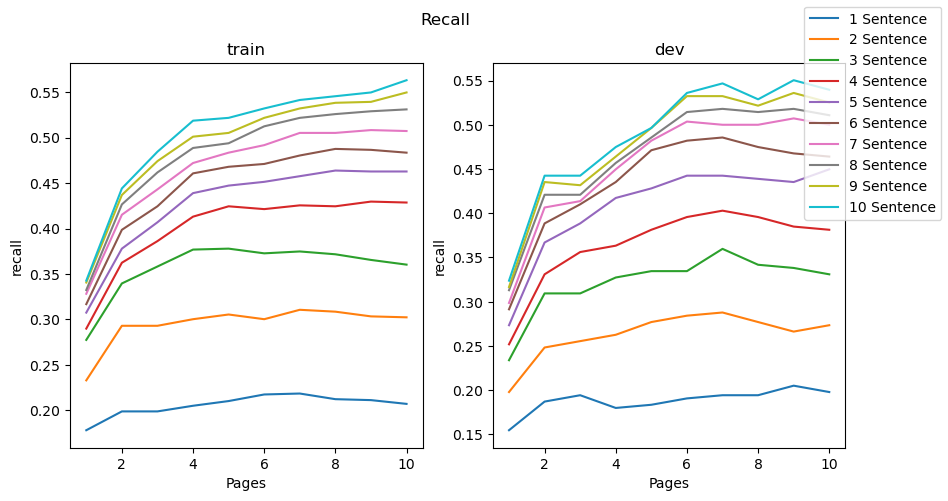

In [36]:
fig_r, ax_r = plot_evidence_curves(df_evnomax, x_is_page=True, metric="recall", suptitle="Recall")

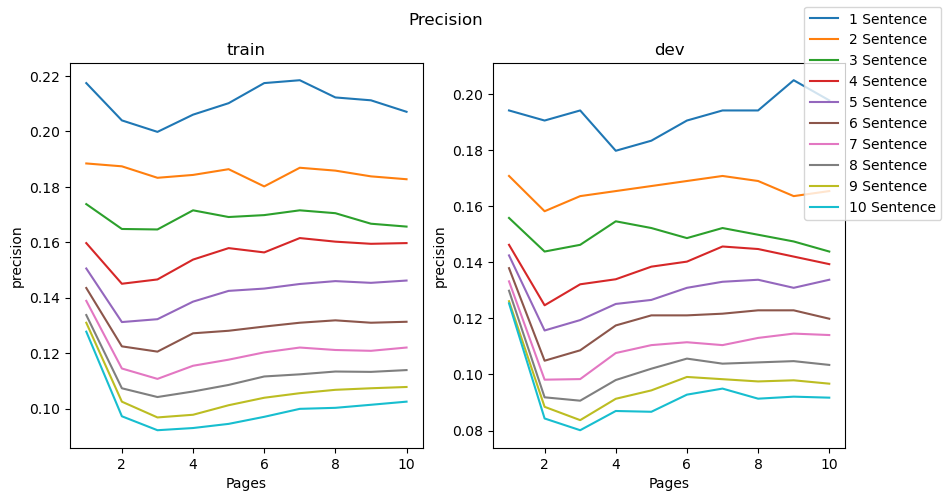

In [37]:
fig_p, ax_p = plot_evidence_curves(df_evnomax, x_is_page=True, metric="precision", suptitle="Precision")

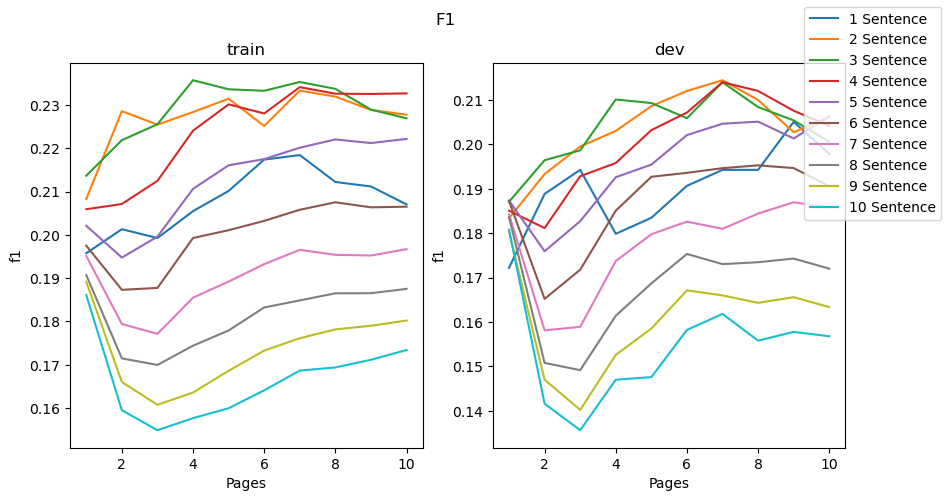

In [38]:
fig_f1, ax_f1 = plot_evidence_curves(df_evnomax, x_is_page=True, metric="f1", suptitle="F1")

# RTE

## Analyse loss curve

In [4]:
model_p = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/rte")

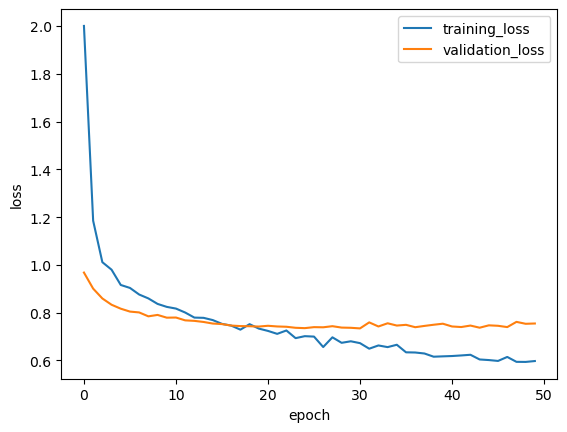

In [5]:
ax, keep_met = evaluate.plot_finetune(model_p / "keep-vocab_model-50epoch", metric="loss", return_metric=True)

In [6]:
keep_met["bias_variance"] = keep_met["training_loss"] - keep_met["validation_loss"]
keep_met[keep_met["bias_variance"] == keep_met.loc[keep_met["bias_variance"] >= 0, "bias_variance"].min()]

,best_epoch,peak_cpu_memory_MB,peak_gpu_0_memory_MB,training_duration,training_start_epoch,training_epochs,epoch,training_accuracy,training_macro_precision,training_macro_recall,...,validation_loss,best_validation_accuracy,best_validation_macro_precision,best_validation_macro_recall,best_validation_macro_fscore,best_validation_micro_precision,best_validation_micro_recall,best_validation_micro_fscore,best_validation_loss,bias_variance
19,15,4682.168,6548,0:00:14.897444,0,15,15,0.651139,0.614022,0.564365,...,0.752446,0.676259,0.611512,0.573559,0.555541,0.676259,0.676259,0.676259,0.752446,0.000853


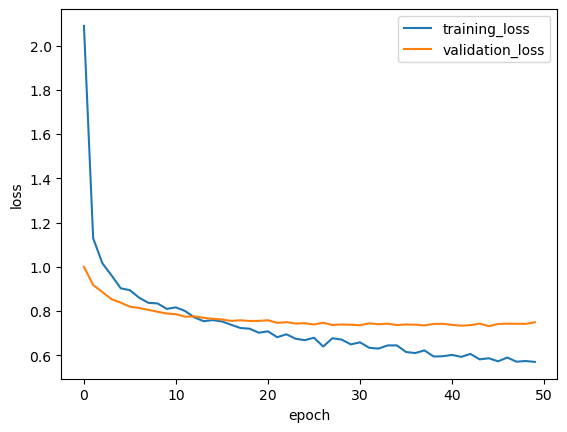

In [7]:
ax, expand_met = evaluate.plot_finetune(model_p / "extend-vocab_model-50epoch", metric="loss", return_metric=True)

In [8]:
expand_met["bias_variance"] = expand_met["training_loss"] - expand_met["validation_loss"]
expand_met[expand_met["bias_variance"] == expand_met.loc[expand_met["bias_variance"] >= 0, "bias_variance"].min()]

,best_epoch,peak_cpu_memory_MB,peak_gpu_0_memory_MB,training_duration,training_start_epoch,training_epochs,epoch,training_accuracy,training_macro_precision,training_macro_recall,...,validation_loss,best_validation_accuracy,best_validation_macro_precision,best_validation_macro_recall,best_validation_macro_fscore,best_validation_micro_precision,best_validation_micro_recall,best_validation_micro_fscore,best_validation_loss,bias_variance
5,9,4700.924,13105,0:00:15.205098,0,9,9,0.658385,0.62861,0.57002,...,0.788482,0.672662,0.601322,0.570881,0.536327,0.672662,0.672662,0.672662,0.788482,0.021012


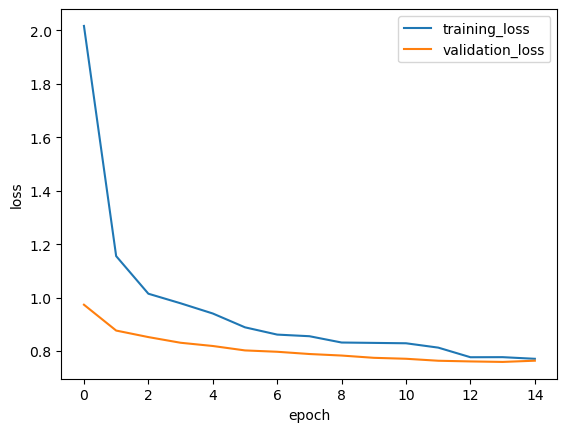

In [9]:
ax, expand_met = evaluate.plot_finetune(model_p / "keep-vocab_model-15epoch", metric="loss", return_metric=True)

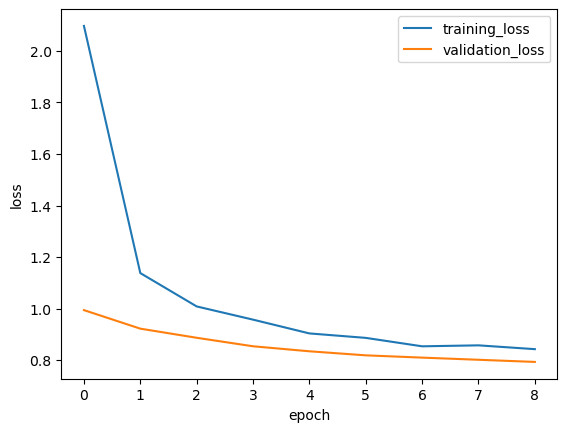

In [10]:
ax, expand_met = evaluate.plot_finetune(model_p / "extend-vocab_model-9epoch", metric="loss", return_metric=True)

## Generate Oracle IR

In [46]:
cf_train = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/dumps/feverised-climatefever/finetune/baseline/climatefever_train.jsonl"))
cf_dev = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/dumps/feverised-climatefever/finetune/baseline/climatefever_dev.jsonl"))

pipeline_p = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/pipeline")

for doc in cf_train:
    doc["predicted_sentences"] = [[ev[0][2], ev[0][3]] for ev in doc["evidence"]]
    
for doc in cf_dev:
    doc["predicted_sentences"] = [[ev[0][2], ev[0][3]] for ev in doc["evidence"]]
    
write_jsonl(ir_p / "climatefever_oracle_train.jsonl", cf_train)
write_jsonl(ir_p / "climatefever_oracle_dev.jsonl", cf_dev)

## Evaluate Pipeline

Oracle IR is the absolute best the model can achieve assuming IR is perfect

In [47]:
def multi_rte_score(actual_train, actual_dev, predicted_p):
    predicted_train = read_data(predicted_p / "pred.train.jsonl")
    predicted_dev = read_data(predicted_p / "pred.dev.jsonl")
    
    key = predicted_p.stem
    return {
        key: {
            "train": evaluate.ClimateFEVERScorer(actual_train, [{"predicted": pred["predicted_label"]} for pred in predicted_train], oracle_ir=True, oracle_rte=False, max_evidence=None, score_name=f"{key}_train"),
            "dev": evaluate.ClimateFEVERScorer(actual_dev, [{"predicted": pred["predicted_label"]} for pred in predicted_dev], oracle_ir=True, oracle_rte=False, max_evidence=None, score_name=f"{key}_dev")
        }
    }

In [48]:
pipeline_keep = pipeline_p / "keep-vocab"
pipeline_extend = pipeline_p / "extend-vocab"

keep_rte_eval = Parallel(n_jobs=20)(delayed(multi_rte_score)(cf_train, cf_dev, p) for p in pipeline_keep.iterdir())
with pipeline_p.joinpath("eval_keep-vocab.pkl").open("wb") as fn:
    pkl.dump(keep_rte_eval, fn)
    
extend_rte_eval = Parallel(n_jobs=20)(delayed(multi_rte_score)(cf_train, cf_dev, p) for p in pipeline_extend.iterdir())
with pipeline_p.joinpath("eval_extend-vocab.pkl").open("wb") as fn:
    pkl.dump(extend_rte_eval, fn)

In [49]:
with pipeline_p.joinpath("eval_keep-vocab.pkl").open("rb") as fn:
    keep_rte_eval = pkl.load(fn)
    
with pipeline_p.joinpath("eval_extend-vocab.pkl").open("rb") as fn:
    extend_rte_eval = pkl.load(fn)

In [65]:
def rte_eval_to_df(eval_ls):
    df = []
    for i in eval_ls:
        k = list(i.keys())[0]
        v = i[k]

        eval_d = {}
        p, s = re.findall(r"p(\d{1,2})s(\d{1,2}).*", k)[0]
        p, s = int(p), int(s)
        if p == 0 and s == 0:
            key = "oracle_ir"
        else:
            key = "p" + (f"0{p}" if p <= 9 else "10") + "s" + (f"0{s}" if s <= 9 else "10")

        eval_d["n_pages"] = p
        eval_d["n_sents"] = s
        eval_d["ir_type"] = key

        for split, res in v.items():
            for name, met in res.rte_metrics.items():
                eval_d[f"{split}_{name}"] = met
        df.append(eval_d)

    df = pd.DataFrame(df).sort_values(["n_pages", "n_sents"])
    
    return df

In [66]:
df_keep = rte_eval_to_df(keep_rte_eval)
df_extend = rte_eval_to_df(extend_rte_eval)

In [83]:
df_keep.nlargest(2, "dev_macro_f1")

,n_pages,n_sents,ir_type,train_accuracy,train_micro_precision,train_micro_recall,train_micro_f1,train_macro_precision,train_macro_recall,train_macro_f1,dev_accuracy,dev_micro_precision,dev_micro_recall,dev_micro_f1,dev_macro_precision,dev_macro_recall,dev_macro_f1
33,0,0,oracle_ir,0.654244,0.654244,0.654244,0.654244,0.621763,0.551558,0.542165,0.636691,0.636691,0.636691,0.636691,0.477751,0.514909,0.481011
12,5,4,p05s04,0.451346,0.451346,0.451346,0.451346,0.448769,0.389805,0.353835,0.478417,0.478417,0.478417,0.478417,0.478639,0.409776,0.374749


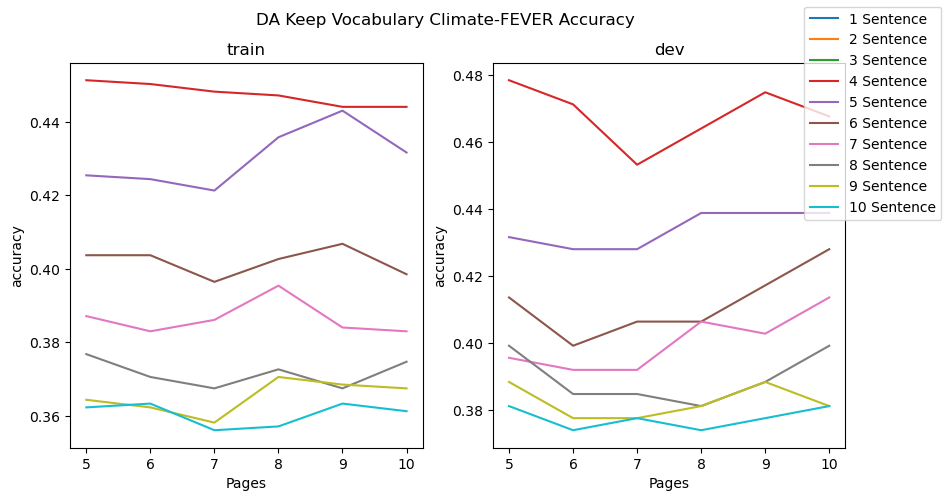

In [79]:
fig_fs, ax_fs = plot_evidence_curves(df_keep, x_is_page=True, metric="accuracy", suptitle="DA Keep Vocabulary Climate-FEVER Accuracy")

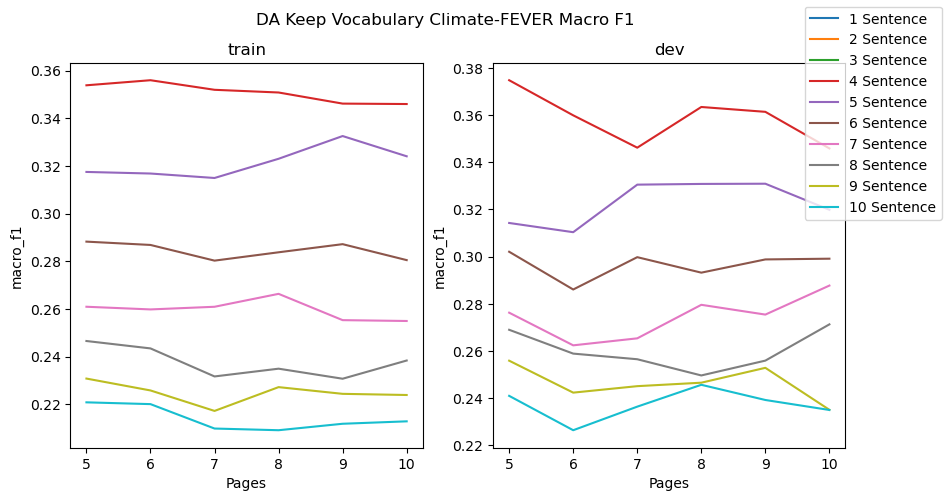

In [80]:
fig_fs, ax_fs = plot_evidence_curves(df_keep, x_is_page=True, metric="macro_f1", suptitle="DA Keep Vocabulary Climate-FEVER Macro F1")

In [78]:
df_extend.nlargest(2, "dev_macro_f1")

,n_pages,n_sents,ir_type,train_accuracy,train_micro_precision,train_micro_recall,train_micro_f1,train_macro_precision,train_macro_recall,train_macro_f1,dev_accuracy,dev_micro_precision,dev_micro_recall,dev_micro_f1,dev_macro_precision,dev_macro_recall,dev_macro_f1
33,0,0,oracle_ir,0.581781,0.581781,0.581781,0.581781,0.561723,0.498640,0.504402,0.597122,0.597122,0.597122,0.597122,0.543538,0.498486,0.498038
20,9,5,p09s05,0.475155,0.475155,0.475155,0.475155,0.479513,0.413898,0.420871,0.496403,0.496403,0.496403,0.496403,0.473262,0.437921,0.444003


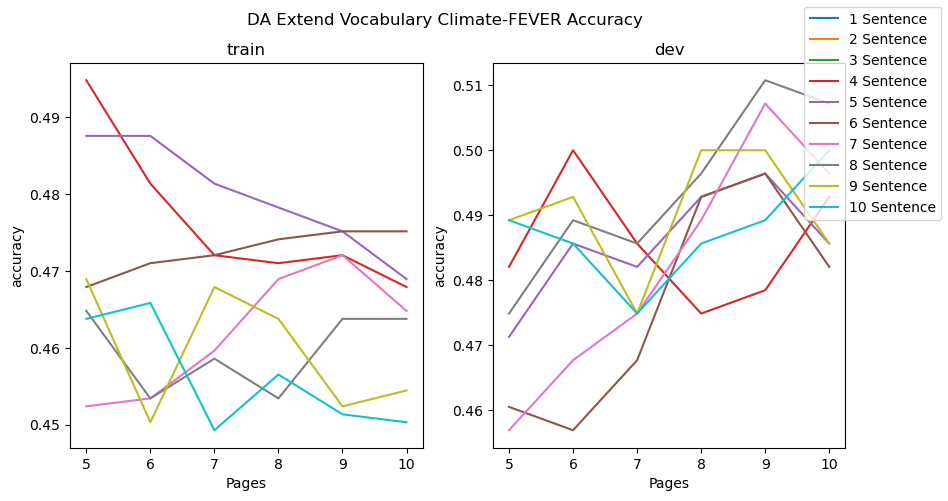

In [81]:
fig_fs, ax_fs = plot_evidence_curves(df_extend, x_is_page=True, metric="accuracy", suptitle="DA Extend Vocabulary Climate-FEVER Accuracy")

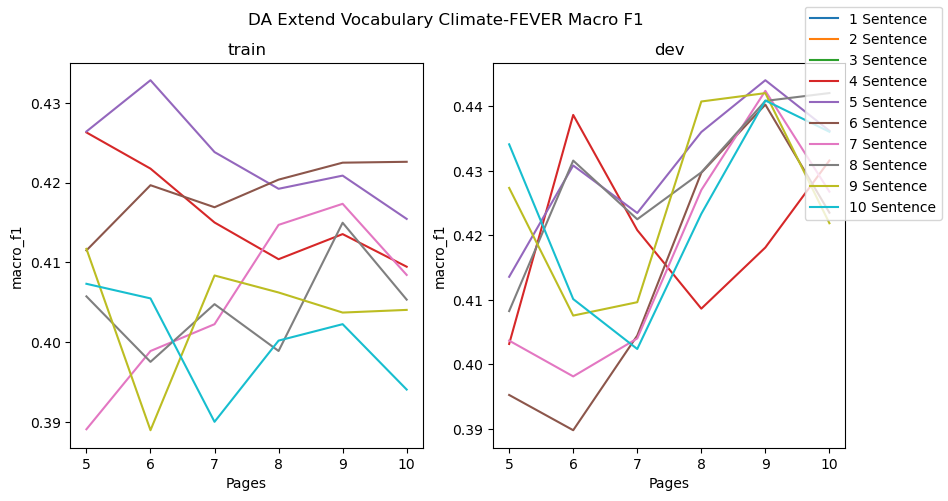

In [82]:
fig_fs, ax_fs = plot_evidence_curves(df_extend, x_is_page=True, metric="macro_f1", suptitle="DA Extend Vocabulary Climate-FEVER Macro F1")

### Compare between best keep/extend vocabulary and zero-shot Climate-FEVER

In [94]:
from sklearn.metrics import classification_report

In [96]:
cfever_p5s5_zeroshot = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/cfever_zeroshot/dev/pred.climatefever_dev.jsonl"))
print(classification_report(y_true=[doc["label"] for doc in cf_dev], y_pred=[pred["predicted_label"] for pred in cfever_p5s5_zeroshot]))

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.46      0.13      0.20        95
        REFUTES       0.20      0.37      0.26        51
       SUPPORTS       0.59      0.69      0.63       132

       accuracy                           0.44       278
      macro avg       0.41      0.40      0.36       278
   weighted avg       0.47      0.44      0.42       278



In [92]:
for i in keep_rte_eval:
    if list(i.keys())[0] == "p5s4":
        best_keep = i
        break
print(best_keep["p5s4"]["dev"].classification_report)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.38      0.71      0.50        95
        REFUTES       0.40      0.04      0.07        51
       SUPPORTS       0.65      0.48      0.56       132

       accuracy                           0.48       278
      macro avg       0.48      0.41      0.37       278
   weighted avg       0.51      0.48      0.45       278



In [90]:
for i in extend_rte_eval:
    if list(i.keys())[0] == "p9s5":
        best_extend = i
        break
print(best_extend["p9s5"]["dev"].classification_report)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.40      0.44      0.42        95
        REFUTES       0.44      0.24      0.31        51
       SUPPORTS       0.58      0.64      0.60       132

       accuracy                           0.50       278
      macro avg       0.47      0.44      0.44       278
   weighted avg       0.49      0.50      0.49       278

